# Text Mining 2021: Práctico de Clústering

Facultad de Matemática, Astronomía, Física y Computación

Estudiante: Juan Cruz Barsce

---

# Enunciados

## Objetivos
1. En un corpus de texto general en castellano, encontrar grupos de palabras que puedan ser usados como clases de equivalencia. 

## Soluciones de ejemplo de text mining 2017

* [clustering de palabras de Dani Bosch](https://github.com/danibosch/word_clustering/blob/master/clustering.ipynb) (con Spacy)

* [clustering de palabras de Facu Molina](https://github.com/facumolina/textmining-clustering/blob/master/word-clustering.py) (con gensim)

### Entregable

Fecha de entrega:

*   13 de septiembre presentación en clase

*   24 de septiembre primera entrega y discusión en clase

*   1 de octubre presentación del informe (github)

Material a entregar (digital, no papel): Una página web con una notebook ejecutable (tipo github o colab) con:

1.   descripción del preproceso aplicado al corpus

1.   descripción de la herramienta de clustering utilizada

1.   listado de los parámetros usados en la(s) solucion(es) de clustering que se presentan, y lo que se esperaba a priori de cada configuración de parámetros

1.   discusión de la(s) solucion(es) de clustering elegidas: descripción global de la solución (número de clusters, cantidad de elementos por cluster, distribución de características, algunas métricas) y descripción cualitativa de algunos clusters

## Procedimiento (independiente para cada uno de los objetivos)

1.    Obtener un corpus de la lengua española (por ejemplo, alguno del SBWCE de Cristian Cardellino, o, a falta de mejores opciones, se pueden usar los que hay en mi directorio de corpus).

1.    Preprocesarlo para normalizar las palabras, con SpaCy, NLTK o Freeling. Se pueden realizar análisis morfosintáctico o sintáctico, de forma de enriquecer la información asociada a palabras, por ejemplo, con triplas de dependencias.

1.    Vectorizar las palabras (para el objetivo 1) o las entidades nombradas (para el objetivo 2) (quizás usando el vectorizador de scikitlearn o una heurística propia).  Aplicar reducción de dimensionalidad mediante umbral de frecuencia.

1.    Aplicar embeddings: LSA o word embeddings neuronales.

1.    Obtener clusters de palabras.

1.    Analizar los clusters, iterar a 3.

## Criterios de corrección

1.    Si se realizan los pasos básicos sin ninguna omisión, 8

1.    Si se realizan los pasos básicos con algunas omisiones, entre 6 y 7

1.    Si se usan triplas de dependencias, 9

1.    Si se usan embeddings (neuronales o LSA), 9

1.    Si se usan triplas y embeddings, 10

---

# Resolución

1.    Obtener un corpus de la lengua española (por ejemplo, alguno del SBWCE de Cristian Cardellino, o, a falta de mejores opciones, se pueden usar los que hay en mi directorio de corpus).

Cargamos uno de los corpus SBWCE de Cristian Cardellino.

In [1]:
from collections import defaultdict
import glob

import numpy as np
import spacy

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.manifold import TSNE

from gensim.models import Word2Vec

import matplotlib.pyplot as plt

nlp = spacy.load("es_core_news_lg")

# vemos la pipeline de spacy que vamos a usar
nlp.pipe_names

['tok2vec', 'morphologizer', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [2]:
# usamos modo de test? (el modo de test está armado para iterar sobre una parte minúscula del corpus
# de modo tal de ir rápida desde el inicio a fin del notebook, pudiendo hacer pruebas)
test_mode = True

2.    Preprocesarlo para normalizar las palabras, con SpaCy, NLTK o Freeling. Se pueden realizar análisis morfosintáctico o sintáctico, de forma de enriquecer la información asociada a palabras, por ejemplo, con triplas de dependencias.

Vamos a recorrer oración por oración, y token por token.

In [3]:
# función de lematización, y remoción de stopwords y de caracteres no alfabéticos usando spacy.

def process_line(line):
    lemma_line = []
    tripla = []
    
    line = nlp(line)
    for token in line:
        # construimos el contexto de cada oración
        if not token.is_stop and token.is_alpha \
        and not token.is_digit:
            lemma_line.append(token.lemma_)
            
            # extracción de triplas, basada en 
            # https://github.com/danibosch/word_clustering/blob/master/clustering.ipynb
            tripla.append((token.lemma_, token.dep_, token.head.lemma_))
        
    return lemma_line, tripla

In [4]:
# en esta función transformamos una línea en un diccionario que cuenta 
# la cantidad de ocurrencias de cada palabra, para que sirva de entrada
# del DictVectorizer

# basado en el ejemplo de Sklearn: https://scikit-learn.org/stable/auto_examples/text/plot_hashing_vs_dict_vectorizer.html#sphx-glr-auto-examples-text-plot-hashing-vs-dict-vectorizer-py

"""
En esta función transformamos una línea en un diccionario que cuenta 
la cantidad de ocurrencias de cada palabra (o triplas) en la misma, 
para que sirva de entrada del objeto DictVectorizer
"""
def line2dict(line, counter):
    """Extract a dict mapping tokens from doc to their frequencies."""
    freq = defaultdict(int)
    for tok in line:
        freq[tok] += 1
        counter[tok] += 1
            
    return freq

In [5]:

path = 'data/1/clean_corpus/spanish_billion_words/spanish_billion_words_42'

# leemos uno de los archivos del corpus, cargando cada linea en all_lines 
# basado inicialmente en: https://stackoverflow.com/questions/52467936/read-corpus-of-text-files-in-spacy

# nuestra estructura básica, lines_dict, contendrá un diccionario con 
# las palabras que ocurrieron en cada línea, de modo de servir de fácil
# entrada al DictVectorizer, para procesarlo a partir de ahí
lines_dict = []

tripla_dict = []
tripla_counter = defaultdict(int)

# lines_raw almacena cada palabra que ocurrió en cada línea sin convertir
# en dict, para que sirva de entrada a nuestro modelo gensim

lines_raw = []
word_counter = defaultdict(int)


for file in glob.glob(path):
    with open(file, encoding='utf-8', errors='ignore') as file_in:
        text = file_in.read()
        lines = text.split('\n')
        
        # recorremos línea por línea
        for idx2, line in enumerate(lines):

            line, tripla = process_line(line)
            lines_raw.append(line)
            
            line_dict = line2dict(line, word_counter)
            lines_dict.append(line_dict)
            
            line_tripla = line2dict(tripla, tripla_counter)
            tripla_dict.append(line_tripla)
            
            if test_mode and idx2 > 10000:
                break

In [6]:
# vemos la cabeza de lines_dict

print(lines_dict[:5])

[defaultdict(<class 'int'>, {'Subprocurador': 1, 'agresión': 1, 'puño': 1, 'cauce': 1, 'fractura': 1, 'hueso': 1, 'cara': 1, 'caso': 1, 'mujer': 1, 'estructura': 1, 'óseo': 1, 'suave': 1, 'y': 3, 'delicado': 1, 'sobretodo': 1, 'golpe': 1, 'fuerte': 1, 'hombre': 1, 'dedicar': 1, 'a': 1, 'rudo': 1}), defaultdict(<class 'int'>, {'Alemania': 1, 'y': 1, 'Portugal': 1, 'inaugurar': 1, 'emisión': 1, 'deuda': 1, 'DIGITO': 4, 'anuncio': 1, 'precedido': 1, 'aceleración': 1, 'proceso': 1, 'culminar': 1, 'mitin': 1, 'campaña': 1, 'presidencial': 1}), defaultdict(<class 'int'>, {'contexto': 1, 'Tobalina': 1, 'calificar': 1, 'error': 1, 'utilizar': 1, 'televisión': 1, 'canguro': 1, 'y': 2, 'niño': 1, 'molestar': 1, 'menor': 1, 'capacidad': 1, 'dosificar él': 1, 'adoptar': 1, 'práctica': 1, 'rutina': 1}), defaultdict(<class 'int'>, {'aliancista': 1, 'criticar': 1, 'a': 2, 'Juan': 1, 'Carlos': 1, 'Lastiri': 1, 'Quirós': 1, 'aspirante': 1, 'Senado': 1, 'PRI': 1, 'calificar': 1, 'pillo': 1, 'y': 1, 'sen

In [7]:
# vemos la cabeza de lines_raw

print(lines_raw[:5])

[['Subprocurador', 'agresión', 'puño', 'cauce', 'fractura', 'hueso', 'cara', 'caso', 'mujer', 'estructura', 'óseo', 'suave', 'y', 'delicado', 'y', 'sobretodo', 'golpe', 'fuerte', 'y', 'hombre', 'dedicar', 'a', 'rudo'], ['Alemania', 'y', 'Portugal', 'inaugurar', 'emisión', 'deuda', 'DIGITO', 'DIGITO', 'DIGITO', 'DIGITO', 'anuncio', 'precedido', 'aceleración', 'proceso', 'culminar', 'mitin', 'campaña', 'presidencial'], ['contexto', 'Tobalina', 'calificar', 'error', 'utilizar', 'televisión', 'canguro', 'y', 'niño', 'molestar', 'menor', 'capacidad', 'dosificar él', 'y', 'adoptar', 'práctica', 'rutina'], ['aliancista', 'criticar', 'a', 'Juan', 'Carlos', 'Lastiri', 'Quirós', 'aspirante', 'Senado', 'PRI', 'a', 'calificar', 'pillo', 'y', 'sentenciar', 'buscar', 'constante', 'fuero', 'evadir', 'responsabilidad', 'Auditoría', 'Superior', 'Federación', 'ASF', 'emitir', 'observación', 'DIGITO', 'DIGITO', 'DIGITO', 'millón', 'pesos', 'gestión', 'secretario', 'Desarrollo', 'Social', 'SDS'], ['Xelajú

In [8]:
# vemos algunas triplas
tripla_dict[:2]

[defaultdict(int,
             {('Subprocurador', 'nsubj', 'expresar'): 1,
              ('agresión', 'nsubj', 'sí'): 1,
              ('puño', 'nmod', 'agresión'): 1,
              ('cauce', 'obj', 'sí'): 1,
              ('fractura', 'amod', 'cauce'): 1,
              ('hueso', 'obl', 'sí'): 1,
              ('cara', 'nmod', 'hueso'): 1,
              ('caso', 'obl', 'tener'): 1,
              ('mujer', 'nmod', 'caso'): 1,
              ('estructura', 'obj', 'tener'): 1,
              ('óseo', 'amod', 'estructura'): 1,
              ('suave', 'amod', 'estructura'): 1,
              ('y', 'cc', 'delicado'): 1,
              ('delicado', 'conj', 'suave'): 1,
              ('y', 'cc', 'sobretodo'): 1,
              ('sobretodo', 'conj', 'suave'): 1,
              ('golpe', 'nsubj', 'fuerte'): 1,
              ('fuerte', 'advcl', 'tener'): 1,
              ('y', 'cc', 'tratar'): 1,
              ('hombre', 'obj', 'tratar'): 1,
              ('dedicar', 'acl', 'hombre'): 1,
              

---

3.    Vectorizar las palabras (para el objetivo 1) o las entidades nombradas (para el objetivo 2) (quizás usando el vectorizador de scikitlearn o una heurística propia).  Aplicar reducción de dimensionalidad mediante umbral de frecuencia.



### Vectorización 1: convertimos dict de frecuencias por cada oración en una matriz de frecuencia por palabra

In [9]:

dv = DictVectorizer()  

# usamos el DictVectorizer, para poder transformar la info de lines_dict en
# una enooorme matriz sparse, en donde cada fila representa una palabra, 
# y cada columna representa su contexto, en este caso, las palabras que la
# acompañaron en cada oración
X = dv.fit_transform(lines_dict)

In [10]:
# hacemos un check rápido para ver que si features se extrajeron bien
labels = dv.feature_names_
dv.feature_names_[:10]

['A', 'AA', 'AAA', 'AARM', 'AB', 'ABC', 'ABI', 'AC', 'ACAV', 'ACB']

In [11]:
np.shape(dv.feature_names_)

(23971,)

In [12]:
support = []
ocurrencias_minimas = 100
ocurrencias_máximas = 7000

# definimos las palabras a conservar según la cantidad de ocurrencias
# en este caso, eliminamos las palabras cuyas ocurrencias minimas fueron < 100
for key in dv.vocabulary_:
    support.append((dv.vocabulary_[key] > ocurrencias_minimas) & (dv.vocabulary_[key] < ocurrencias_máximas))
    
# quitamos las palabras con menos ocurrencias
dv.restrict(support)
X_reduced = dv.transform(lines_dict)

In [13]:
np.shape(X)

(10002, 23971)

In [14]:
# normalizamos aplicando el TF IDF Transformer a nuestra matriz

tfidf = TfidfTransformer()
X_t = tfidf.fit_transform(X)


### Vectorización 2: convertimos nuestro contexto en matriz de frecuencias

In [15]:
dv_triplas = DictVectorizer()
X_context = dv_triplas.fit_transform(tripla_dict)

In [16]:
# hacemos un check rápido para ver que si features se extrajeron bien
labels_triplas = dv_triplas.feature_names_
dv_triplas.feature_names_[:10]

[('A', 'advmod', 'recordar'),
 ('A', 'appos', 'película'),
 ('A', 'case', 'AA'),
 ('A', 'case', 'AHDIGITO'),
 ('A', 'case', 'B'),
 ('A', 'case', 'C'),
 ('A', 'case', 'DIGITO'),
 ('A', 'case', 'Different'),
 ('A', 'case', 'Discusión'),
 ('A', 'case', 'HDIGITO')]

**Nota: falta continuar el trabajo con las triplas, todavía es Work In Process**  ⚒️

---

4.    Aplicar embeddings: LSA o word embeddings neuronales.
5.    Obtener clusters de palabras.
6.    Analizar los clusters, iterar a 3.

Para estos enunciados vamos a usar algunas variantes, en cada una de ellas aplicamos una técnica a nuestro conjunto de datos, y luego aplicamos clústering.

### Variante 0: Clustering directo

In [17]:
# aplicamos clustering directamente sobre la matriz TF-IDF

n_clusters = 10

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
X_direct = kmeans.fit_transform(X_t)
y_direct = kmeans.predict(X_t)

In [18]:
# vemos los términos más cercanos al centro de cada clúster

for cluster in range(n_clusters):
    X_cluster = X_direct[y_direct == cluster]
    idx_sort = np.argsort(X_cluster[:,cluster])
    if np.shape(idx_sort)[0]>10:
        words = [dv.feature_names_[x] for x in idx_sort[:10]]

    print("Clúster %d:" % cluster, end='')
    for w in words:
        print(' %s' % w, end='')
    print()

Clúster 0: Starbucks Interterritorial Burócrata Nacif Vucetich Martijn Pavone Montoto Maestro Depp
Clúster 1: Batamote Buendía Analistas Citlálic Chou Collado Alsea Cohn Carano Berlusconi
Clúster 2: Carballo Cristóbal Biden CIUDAD Anton Bordo Centroamérica Adha Conagua Círculo
Clúster 3: Aficionados Ariel Cardinales Arbeloa Aston Chevron Chera Baudilio Cambio Alicia
Clúster 4: Akihito INXS Dresden Althingi Caltech Alta Angeles Cerén Jalapa Matilda
Clúster 5: Mgaña Lonis Donis Armados DVD Choix Picarropa Mexicano Valsequillo Sirio
Clúster 6: Aqua Batasuna Bashar BR Beatles Bachelet Aprehensiones Atexcal Ajusco Alcohol
Clúster 7: Aicardo Alicia Animación Albert Alaputenses Asistencia Baldwin Arnaud Ascenso Anastrazol
Clúster 8: Bogdanovic Liberación Cundapí Drawing Licata Cerón NOAA PAÍS Leicester García
Clúster 9: Asia Capulina Caltech Anton Comisionado Aprilia Costumbres Cerón Códice Aicardo


Vemos a simple vista que los resultados no están muy buenos, y hay muchísimo solapamiento

---

### Variante 1: Aplicamos Latent Semantical Analysis

In [19]:

# usamos TruncatedSVD para agilizar el cálculo de la descomposición, 
# debido a la enorme matriz con la que estamos trabajando

svd = TruncatedSVD(n_components=50)
X_svd = svd.fit_transform(X_t)


In [20]:
np.shape(X_svd)

(10002, 50)

In [21]:

n_clusters = 10

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
X_lsa = kmeans.fit_transform(X_svd)
y_lsa = kmeans.predict(X_svd)

In [22]:
# obtenemos centroides y vemos clústers (basado en tutorial de sklearn)

for cluster in range(n_clusters):
    X_lsa_cluster = X_lsa[y_lsa == cluster]
    idx_sort = np.argsort(X_lsa_cluster[:,cluster])
    words = [dv.feature_names_[x] for x in idx_sort[:10]]

    print("Clúster %d:" % cluster, end='')
    for w in words:
        print(' %s' % w, end='')
    print()

Clúster 0: Adjunto Bergman Camarón Balkimi Calaveras Carballo Boy Atómica Blackberry Animación
Clúster 1: Basta Charles Alicia Astros Analistas Centroamericana Caltech Albán Chandelle Calamidad
Clúster 2: Oliva Transportación Europeo Faull Luque Sylvain Mineros LP Halver Urbanismo
Clúster 3: Alvarez Arnold Associated Adico Armados Belsito Arauca Beat Aguilar Atlántica
Clúster 4: Aracataca Inzunza Ikea Balenciaga Hummer Contraloría Alzheimer Administraciones Diana Banda
Clúster 5: Kaká Estrategia Inversiones Edil Ejército Joselyn Fraunhofer Financieros DSK Henestrosa
Clúster 6: Charly Ayuda Eurocopter CNT Aquilés Consuegra Bielous Consternación Animación Alfons
Clúster 7: Bruni Cassez Astorga Cardona Alicia Belén Bescam Coproder Curiosity Chopera
Clúster 8: Kutcher Poehler Soberana Redistritación Constancia Señoritas Intermedio Sobrevivientes Montaner Joseph
Clúster 9: Bergman Atlántico Anton Arauca Arganzuela Berta Aficionados Aldo Aguilar Ayup


Vemos que va clasificando algo mejor, se reconocen parecidos en varios clústers.
Ejemplo:

Tenemos Clúster de deportes!
> Clúster 6: Bordados Novak Bayer doblegar Juventus Huitussi Orión Bundesliga regularidad Pavone

y de economía
> Clúster 3: cápita aumenten inflexible DPI subsector agroalimentario saturado determinant imputable paradigma

### Variante 2: usamos Latent Dirichlet Allocation

In [23]:
lda = LatentDirichletAllocation(n_components=20, random_state=42)
X_lda = lda.fit_transform(X_t)

In [24]:
# vemos los tópicos - basado en ejemplo de scikit-learn: 
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

n_top_words = 10

for topic_idx, topic in enumerate(lda.components_):
    top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
    top_features = [labels[i] for i in top_features_ind]
    weights = topic[top_features_ind]

    print('Tópico {}: '.format(topic_idx +1) + ' '.join(top_features))
    print('Pesos : ' + ' '.join([str('%.0f'% weights[i]) for i in range(len(weights))]))
    print()

Tópico 1: DIGITO y a digito año lesionado tener caso o mes
Pesos : 31 20 17 8 4 4 3 3 3 3

Tópico 2: DIGITO y a digito campaña elección Nieto Peña presidencial presidente
Pesos : 52 24 22 9 6 6 5 5 5 5

Tópico 3: a y DIGITO o suceder digito Justicia haber magistrado detectar
Pesos : 10 10 7 4 3 3 3 2 2 2

Tópico 4: a y DIGITO naturaleza Unidos ciudad francés cosa equipo año
Pesos : 13 12 9 3 3 3 3 3 2 2

Tópico 5: a DIGITO y digito semana presente año Nacional presentar público
Pesos : 17 15 13 3 3 3 3 2 2 2

Tópico 6: y a DIGITO o utilizar Rajoy Mariano normal grande año
Pesos : 14 12 10 5 3 3 3 3 2 2

Tópico 7: y a DIGITO decir sospechoso temperatura o nublado viento digito
Pesos : 11 9 9 5 3 3 2 2 2 2

Tópico 8: DIGITO a y año digito fondo fan encontrar buscar importar
Pesos : 16 15 13 5 3 3 2 2 2 2

Tópico 9: DIGITO y a país equipo año digito jugar grupo XVI
Pesos : 34 18 17 6 6 5 5 3 3 3

Tópico 10: y DIGITO a López Obrador llegar tema volver año candidato
Pesos : 13 11 11 5 4 4 4

In [25]:
top_features

['DIGITO',
 'y',
 'a',
 'digito',
 'o',
 'año',
 'Fondo',
 'mundo',
 'investigación',
 'Monetario']

Vemos que va mejorando, se vislumbran varios tópicos. También puede apreciarse que DIGITO aparece en todos los clústers.

Algunos picks:
> Tópico 2: DIGITO y a digito campaña elección Nieto Peña presidencial presidente

> Tópico 10: y DIGITO a López Obrador llegar tema volver año candidato

> Tópico 16: DIGITO a y digito año ciento millón mil peso dólares


### Variante 3: usamos word2vec

In [26]:
# usamos gensim para esto

model = Word2Vec(sentences=lines_raw, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")


In [27]:
model = Word2Vec.load("word2vec.model")

# alimentamos al modelo con lines_raw definido arriba
model.train(lines_raw, total_examples=len(lines_raw), epochs=100)

(14126116, 16460900)

In [28]:
# vemos las primeras palabras del vocabulario

for idx, key in enumerate(model.wv.key_to_index):
    print(key)
    if idx > 5:
        break

DIGITO
y
a
digito
año
o
país


In [29]:
# proyectamos cada palabra del vocabulario en vectores del espacio de los embeddings

word_vecs = []
vocabulary = list(model.wv.key_to_index)

for key in model.wv.key_to_index:
    word_vecs.append(model.wv[key])

In [30]:
# generamos los clústers

n_clusters = 40

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
X_wvkm = kmeans.fit_transform(word_vecs)
y_wvkm = kmeans.predict(word_vecs)

In [31]:
# vemos los términos más cercanos al centro de cada clúster

for cluster in range(n_clusters):
    mask = X_wvkm[y_wvkm == cluster]
    idx_sort = np.argsort(X_wvkm[:,cluster])
    words = [vocabulary[x] for x in idx_sort[:10]]

    print("Clúster %d:" % cluster, end='')
    for w in words:
        print(' %s' % w, end='')
    print()

Clúster 0: espeso arqueada fragmentación tapa arrollar fúsil forcejeo alacena parrillero glóbulo
Clúster 1: Milan Clausura Alajuelense Djokovic ida Juventus Espanyol Torneo disputado Bundesliga
Clúster 2: Otan desertor Bashar suministrar mataronayer afgana jordano Abdel Balcanes bombardeado
Clúster 3: cápita inflexible Autónomas tributo inflación sustentado ocasional compensar formalización per
Clúster 4: Incendios Forestales Combate FCCT Manejo Folklórica Científico Ganadería Redes Continua
Clúster 5: elite IEE velo eventualmente hacendario fortalecer él organigramas simplificación acelerado sanidad
Clúster 6: Sombrerete Zac Great Emotions Himenoplastía MAK Worcester Dostoiewski Millonarios revertir él
Clúster 7: trastorno cardiovascular agudo diabetes insomnio digestivo infarto diagnosticado crónico pulmón
Clúster 8: reclasificar disponibilidad Devolución Subcuenta Maga quedo trazar él Saldo Fuero sigilo
Clúster 9: Azafato Aldo Ismael Palafox Bautista Velázquez Emiliano Azafata arzob


Por las asociaciones que encuentra, vemos que este método de clústering es el que mejor performa. Tenemos ejemplos interesantes de tópicos (extraídos en una de las ejecuciones, posiblemente hayan cambiado de una ejecución a otra):

Política
> Clúster 1: Panal oficialista senado precandidato Aleida perredista tópico delegacional Senador Alavez

Inglés
> Clúster 11: Sad security Ecology ages Hundreds area evacuated logistics Lost Behavioral

Armas
> Clúster 4: granada casquillo Tsuru estacionado rifle transeúnte AK percutido fusil larga

Justicia:
> Clúster 7: caso queja instancia administrativo amparo extremo Leyva cualquiera superior costumbre

Crimen:
> Clúster 31: percance culposo repeler danés abandono criminalidad derrapar frustrar doloso desertor

Deportes:
> Clúster 23: Novak doblegar Bayer undécimo Orión Juventus Salomón Leverkusen prórroga Schalke
> Juventus doblegar Novak Slam GER Huitussi Bordados Espanyol Bundesliga Open

Sociedad
> Clúster 26: Derechos Humanos Recursos Comisión Interamericana Mujeres Permanente Americana Registro Transparencia
> Clúster 32: Competitividad Bienestar Educativa Deporte Lucha Igualdad Comunicación Conservación Comunitario Tecnología



A raíz de ello, vamos a visualizar un poco mejor.

In [32]:
# visualizamos con t-SNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(word_vecs)

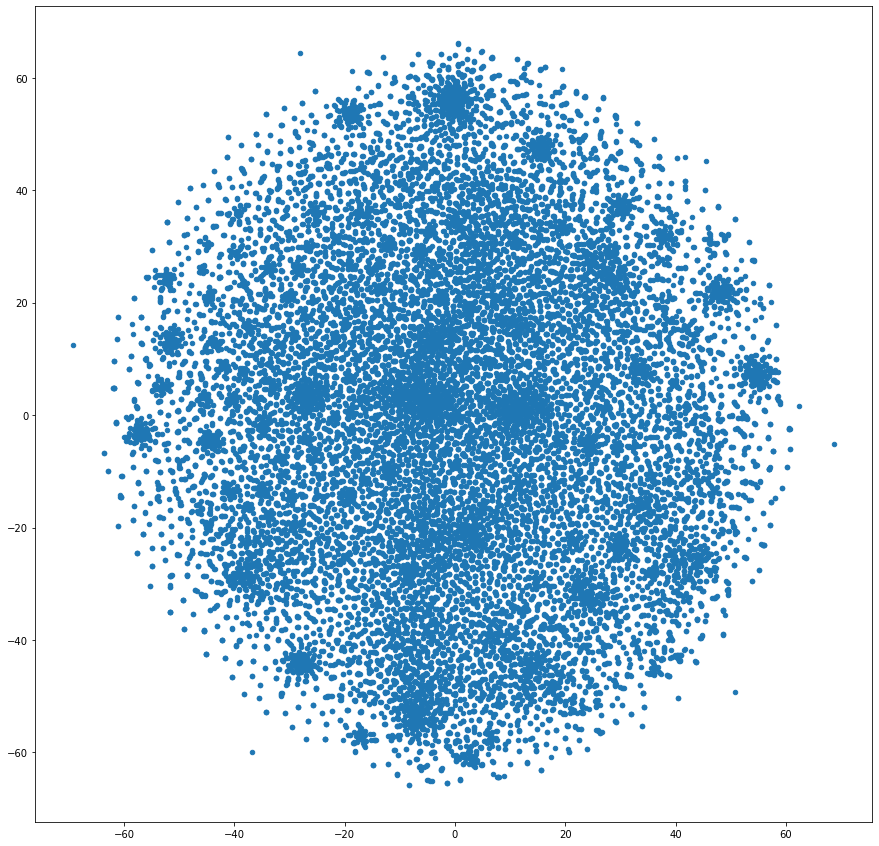

In [33]:
# vemos el blob completo

plt.subplots(figsize=(15, 15))
plt.scatter(X_tsne[:,0], X_tsne[:,1], 20)

Vemos que hay apiñamiento en varias partes del blob. Probamos hacer zoom e identificar por clúster.

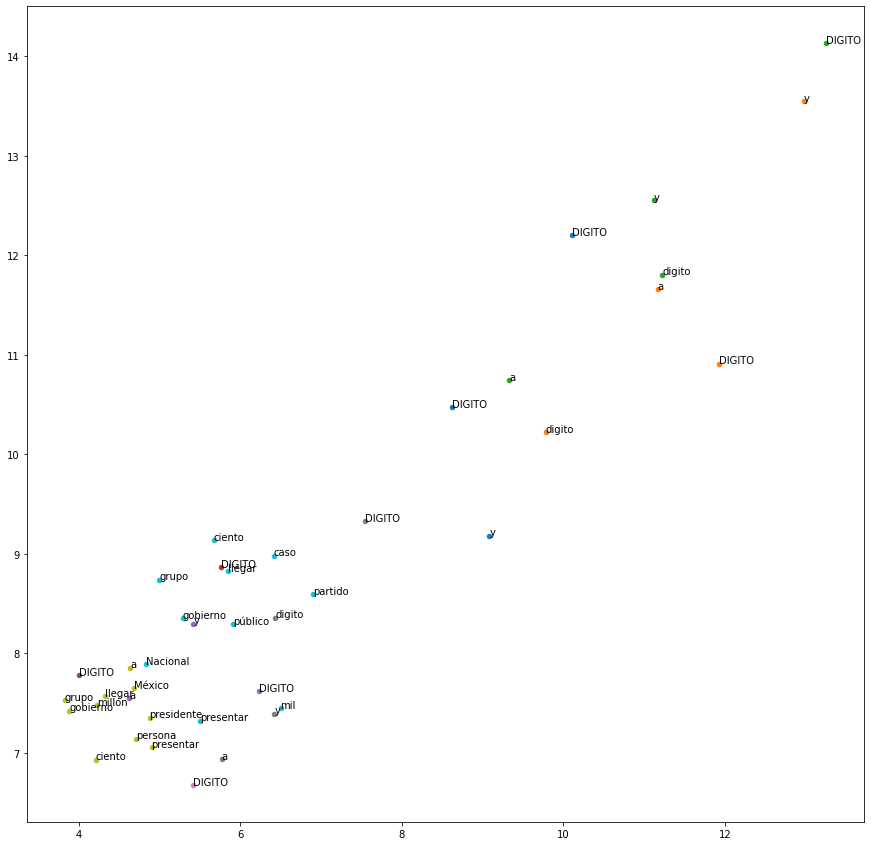

In [34]:
# hacemos zoom ...

# visualizamos, limitando a aquellos términos más cercanos al centro de cada clúster
# (puede haber elementos )
# (basado en https://www.kaggle.com/alvations/word2vec-embedding-using-gensim-and-nltk)

x_zoomed = (0,4)
y_zoomed = (-60,-50)

elements_to_show_per_cluster = 10

mask = (X_tsne[:,0]> x_zoomed[0]) & (X_tsne[:,0] < x_zoomed[1]) & \
       (X_tsne[:,1]> y_zoomed[0]) & (X_tsne[:,1] < y_zoomed[1])

X_tsne_zoomed = X_tsne[mask]
X_wvkm_zoomed = kmeans.transform(np.array(word_vecs)[mask])
y_wvkm_zoomed = kmeans.predict(np.array(word_vecs, dtype=float)[mask])

fig = plt.figure(facecolor='white', figsize=(15,15)) 
ax = plt.axes()

for cluster in range(n_clusters):

    X_wvkm_zoomed_cluster = X_wvkm_zoomed[y_wvkm_zoomed == cluster]
    idx_sort = np.argsort(X_wvkm_zoomed_cluster[:,cluster])
    X_to_plot = np.array([X_wvkm_zoomed_cluster[x] for x in idx_sort[:elements_to_show_per_cluster]])

    if idx_sort.size > 0:

        # Se agregan labels
        for label, x, y in zip([vocabulary[x] for x in idx_sort], X_to_plot[:, 0], X_to_plot[:, 1]):
            ax.annotate(label, xy = (x,y), xytext = (0, 0), textcoords = 'offset points', size = 10)

        ax.scatter(X_to_plot[:,0], X_to_plot[:,1], 20)

        

plt.show()

Vemos en este Zoom-in que el t-SNE agrupa varios términos de clústers similares cerca, y otros, no tanto; en cierto punto parece depender mucho del área donde se realice el zoom-in, y del parecido del término.

Vemos también que aparece DIGITO por varias partes. Por alguna razón que estoy investigando, no pude terminar de hacerle limpieza, a pesar de que busqué filtrarlo con SpaCy y limitando las frecuencias máximas en DictVectorizer.

---

## Referencias

#### Trabajos de referencia
[Trabajo de Dani Bosch](https://github.com/danibosch/word_clustering)

[Trabajo de Facu Molina](https://github.com/facumolina/textmining-clustering)

#### LSA
[Guía de LSA](https://moj-analytical-services.github.io/NLP-guidance/LSA.html)

[Guía de LSA (2)](http://mccormickml.com/2016/03/25/lsa-for-text-classification-tutorial/)

#### SpaCy
[Guía de SpaCy](https://spacy.io/usage/spacy-101), 
[Tokens](https://spacy.io/api/token) y [análisis morfológico](https://spacy.io/api/morphology)

#### Scikit-learn
[Ejemplos sklearn](https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html)

[Ejemplos sklearn (2)](https://scikit-learn.org/stable/modules/decomposition.html#truncated-singular-value-decomposition-and-latent-semantic-analysis)

[Ejemplo de Topic Extraction con LDA](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py)

[DictVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html#sklearn.feature_extraction.DictVectorizer.restrict)

[t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)


#### Gensim
[Ejemplos Word2Vec con Gensim](https://radimrehurek.com/gensim/models/word2vec.html) y [tutorial](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html)

[Ejemplos Word2Vec con Gensim (2)](https://medium.com/swlh/word-embedding-word2vec-with-genism-nltk-and-t-sne-visualization-43eae8ab3e2e)


#### NLP Guidance

[NLP Guidance](https://moj-analytical-services.github.io/NLP-guidance/)

[Glosario NLP](https://moj-analytical-services.github.io/NLP-guidance/Glossary.html)


---

## Mejoras a realizar

* Terminar de implementar el uso de triplas.
* Analizar más contextos, como ventanas de distintos tamaños, n-gramas y ver cómo impactan.
* También, experimentar cómo queda con las stopwords en ventanas más grandes, y realizar un filtrado aún mayor de palabras.
* Hacer mayor búsqueda de híper-parámetros.

### Código sin usar

Bosquejo a mano de extracción de ventanas en cada palabra (**WIP**).

In [35]:
def get_word_context(idx, doc, window):

    context = []
    context_count = {
        'left':0,
        'right':0
    }

    for direction in ['right']:
        i = 1
        sign = 1 if direction == 'right' else -1

        while context_count[direction] < window:
            try:
                token = doc[idx+i]

                context_count[direction] += 1
                context.append(token.lemma_)
                i+=sign
            except IndexError:
                break

    return tuple(context)